<div style="background-color: #f0f0f0; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: 'Times New Roman', serif;text-align: justify;font-size: 16px">

### Description of the project

This project aims to analyze the real estate market in the city of Bologna using a sample of more than 1,500 advertisements collected from the Idealista website. 

**Data scraping process:**
for data scraping, has been used a freemium service called ScraperApi to filter noise within the Idealista website. Opening a free account has more than 900 requests available. 
The use of ScraperApi was necessary for the project due to several countermeasures applied by Idealista to prevent direct web scraping. To avoid unnecessary further credit consumption, is better to save the extracted data as CSV after the first run and worked from it subsequently. 

**Main objectives of the project:**

- **Data collection:** data scraping of 1,500 property listings from the Idealista website to extract relevant information such as price, area, number of rooms, location, and other property characteristics.

- **Econometric Analysis:** econometric procedures to analyze variables influencing property prices and to construct statistical models that identify relationships between different property characteristics and their prices, as well as the distance from the center of the city.

- **Geographical Data:** geographical analysis tools to visualize the distribution of property listings on the map of Bologna. This helped us identify areas with the highest and lowest prices and understand the market dynamics across different areas of the city. As well as potentially find good investments relative to our estimated model
    


In [2]:
#This part of the code includes just all the libraries used for the project

#Useful everywhere libraries
import pandas as pd
import numpy as np
import re

#Data scraping libraries
import csv
import requests
from bs4 import BeautifulSoup   

#Charting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import branca
import branca.colormap as cm
from branca.colormap import LinearColormap

#Regression model
import statsmodels.api as sm

#Geographical data
from tqdm import tqdm
import geopy
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderUnavailable
from geopy.distance import distance
from geopy.geocoders import Nominatim
import folium
import folium.plugins



In [ ]:
api_key = "insert your api_key"
scraper_api_key = api_key
base_url = "https://www.idealista.it/vendita-case/bologna-bologna/"
scraper_api_url = f"https://api.scraperapi.com/?api_key={scraper_api_key}&premium=true&url="


# List with the column name for the csv file
csv_columns = ["Title", "Price", "Bedrooms", "Area", "Description", "Tags", "Image Tags"]
#append the data sequentially in this empty list
extracted_data = []


#Number of pages to extract the data, 
num_pages = 30

for page in range(1, num_pages + 1):
    if page == 1:
        page_url = base_url
    else:
        page_url = f"{base_url}lista-{page}.htm"
    
    full_url = f"{scraper_api_url}{page_url}"
    
    try:
        response = requests.get(full_url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, "html.parser")
        house_listings = soup.find_all("article", class_="item")  # <article class_="item" contains in it all the data we need to scrape
        
        for index, listing in enumerate(house_listings):
            title = listing.find("a", class_="item-link").get("title")  # <a aria-level="2" class="item-link" href="/immobile/30084434/" role="heading" title="Villetta bifamiliare in via Santa Maria, 2, Pilastro, Bologna">
            price = listing.find("span", class_="item-price").text.strip()  # <span class="item-price h2-simulated">285.000<span class="txt-big">€</span></span>
            
            item_details = listing.find_all("span", class_="item-detail")  # <span class="item-detail">7 locali</span><span class="item-detail">223 m2</span></div>
            bedrooms = item_details[0].text.strip() if item_details and item_details[0] else "N/A"  # The numbers of locals are always in the first position
            area = item_details[1].text.strip() if len(item_details) > 1 and item_details[1] else "N/A"  # The area is always in the second position
            
            # There could be other item_details but they are not present in many listings and its appearance
            # in the html does not have the same pattern for all
            
            description = listing.find("div", class_="item-description").text.strip() if listing.find("div", class_="item-description") else "N/A"
            # Example: <div class="item-description description"><p class="highlight-phrase" title="PORZIONE INDIPENDENTE CON GIARDINO PRIVATO">
            
            tags = listing.find("span", class_="listing-tags").text.strip() if listing.find("span", class_="listing-tags") else "N/A"
            # <span class="listing-tags">Occasione</span>
            
            image_elements = listing.find_all('img')
            # <img alt="Prima foto dell'immobile" height="320" loading="lazy" src="https://img4.idealista.it/blur/WEB_LISTING-M/0/id.pro.it.image.master/37/00/c5/590038852.jpg"/>
            image_tags = " , ".join([img.get("alt", "") for img in image_elements]) if image_elements else "N/A"
            image_urls = " , ".join([img.get("src", "") for img in image_elements if img.get("src")]) if image_elements else "N/A"
            
            listing_data = {
                "Title": title,
                "Price": price,
                "Bedrooms": bedrooms,
                "Area": area,
                "Description": description,
                "Tags": tags,
                "Image Tags": image_tags,
                "Image URLs": image_urls
            }
            
            extracted_data.append(listing_data)
            # In this way for each iteration we append the values into a dataframe, after that we plan to save it in a CSV
            # to avoid the scraping process
            
            print(f"Page {page} - Listing {len(extracted_data)}:")  # To know when the code is running at what listing it arrived
            print(f"Title: {title}")
            print(f"Price: {price}")
            print(f"Bedrooms: {bedrooms}")
            print(f"Area: {area}")
            print(f"Description: {description}")
            print(f"Tags: {tags}")
            print(f"Image Tags: {image_tags}")
            print(f"Image URLs: {image_urls}")
            print("=" * 50)  # Used as a separator between listings, so when the code runs it is still possible to
            # understand what the code had scraped. 
    
    except requests.RequestException as e:
        print(f"Error: Unable to retrieve HTML content for page {page}. Status code: {response.status_code}. Error: {e}")
        # Continue to the next page even if there's an error
        continue

In [24]:
df = pd.DataFrame(extracted_data)  #save the list obtained into a dataframe, then save it as .csv
df.to_csv("idealistahousing_datasetfinal.csv",index=False)

In [43]:
df_imported = pd.read_csv("idealistahousing_datasetfinal.csv", sep=",", encoding="utf-8")

# Display the first few rows of the imported dataframe to check if there are issues
print(df_imported.head())


                                               Title       Price   Bedrooms  \
0  Villetta bifamiliare in via Santa Maria, 2, Pi...    285.000€   7 locali   
1                   Villa a Costa Saragozza, Bologna  1.300.000€  11 locali   
2        Bilocale a Santo Stefano - Galvani, Bologna    200.000€   2 locali   
3                 Appartamento a Murri Alta, Bologna    565.000€   5 locali   
4  Quadrilocale in via Camillo Ranzani, 17, San V...    270.000€   4 locali   

     Area                                        Description       Tags  \
0  223 m2  PORZIONE INDIPENDENTE CON GIARDINO PRIVATO\n\n...  Occasione   
1  300 m2  SARAGOZZA LATERALE VIA RONCATI\n\n\nVendesi zo...        NaN   
2   43 m2  ADIACENZE CASTIGLIONE\n\n\nAdiacenze Via Casti...        NaN   
3  110 m2  Vendesi Via Siepelunga zona residenziale, in p...        NaN   
4   98 m2  VIA RANZANI, PORTA SAN DONATO\n\n\nAppartament...        NaN   

                                          Image Tags  \
0  Prima foto dell

<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Dwelling type & address column filtering</h2>
</div>

<div style="font-size: 20px; line-height: 1.6; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
    <img src="Screenshot3.png" alt="Description of the image" title="Optional title" style="width: 2000px;">
    <p style="font-size: 18px; line-height: 1.6; margin-top: 30px;">
        There is a repeating pattern in the listings, composed by the dwelling type + address. Since knowing
        the dwelling type is very important for price estimation, is important to create a new column just for the dwelling type. After that, we can remove the dwelling type from the "title" column to extract the address. To do so, is crucial
        to get rid of the initial "in" and "a" as well as the recurrence of "s.n.c". Additionally, we have to ensure that all listings end with "Bologna". This is very important both for regression part and for geographical data. (for the image above its path must be changed)
    </p>
</div>



In [44]:
# These are all the possible dwelling types seen above from the Idealista website
dwelling_types = ["Villetta bifamiliare", "Villetta a schiera", "Villetta", "Bilocale", "Appartamento su due piani", 
                  "Appartamento", "Villa", "Quadrilocale", "Trilocale", "Casa indipendente", "Monolocale", 
                  "Attico", "Casale/cascina", "Casa rurale", "Loft", "Proprietà rustica"]

# Function to extract dwelling type and filter rows
def process_title(title):
    for dtype in sorted(dwelling_types, key=len, reverse=True):  # This sorts by length to match the longest dwelling type first
        if dtype in title:
            return dtype
    return None

# Use the function above to create a separate column for "DwellingType"
df_imported["DwellingType"] = df_imported["Title"].apply(process_title)
# Filter rows where "DwellingType" is not None (in case there is one missing or not eventually not present in the list above)
df_imported = df_imported[df_imported["DwellingType"].notnull()]

# Now address cleaning

# Function to remove the dwelling type from the address
def remove_dwelling_type(title):
    for dtype in sorted(dwelling_types, key=len, reverse=True):
        if dtype in title:
            title = title.replace(dtype, "")
    return title.strip()

# Use the function to create the "Address" column
df_imported["Address"] = df_imported["Title"].apply(remove_dwelling_type)

# Clean up the "Address" column by replacing "s.n.c" with a space (otherwise the address cannot be identified)
df_imported["Address"] = df_imported["Address"].str.replace("s.n.c", " ", regex=False)

# Replace double commas with a single comma in the address
df_imported["Address"] = df_imported["Address"].str.replace(",  ,", ",", regex=False)

# Remove leading or trailing whitespace characters from the address
df_imported["Address"] = df_imported["Address"].str.strip()

# Function to extract the address from the title using regular expressions. Remove initial "in" or "a".
def extract_address(title):
    address_pattern = re.compile(r"\b(?:in|a)\s+", re.IGNORECASE)
    match = address_pattern.sub("", title)
    # Check if the address ends with "Bologna". If not, append it
    if match and not match.endswith("Bologna"):
        match += ", Bologna"
    return match if match else None

# Apply the function to create the "Address2" column
df_imported["Address2"] = df_imported["Address"].apply(extract_address)

# Drop the first column from df_imported and create a new variable to avoid multiple column removal if the code is run again
df_imported2 = df_imported.drop(df_imported.columns[0], axis=1)

# Display the relevant columns ("DwellingType" and "Address2") to verify the processing
pd.set_option("display.max_rows", None)  # Set to None to display all rows
print(df_imported[["DwellingType", "Address2"]].head())  # Display DwellingType and cleaned Address columns

           DwellingType                                           Address2
0  Villetta bifamiliare              via Santa Maria, 2, Pilastro, Bologna
1                 Villa                           Costa Saragozza, Bologna
2              Bilocale                   Santo Stefano - Galvani, Bologna
3          Appartamento                                Murri Alta, Bologna
4          Quadrilocale  via Camillo Ranzani, 17, San Vitale - Massaren...


<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Geolocation Part</h2>
</div>

<div style="font-size: 18px; line-height: 1.6; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
    <p>
        Using geopy for obtaining the coordinates is useful for us for two reasons:
    </p>
    <ol>
        <li>To extract the address coordinates necessary to calculate the distance between each house listed and a specific point of interest.</li>
        <li>To use the coordinates to locate the position of the house on a map and analyze its price relative to the area in which it is located.</li>
    </ol>
    <p>
        Not all the addresses are identified correctly by the program. This is partly due to issues in reading the full address, as the pattern is not always regular. Consequently, sometimes (less than 3% of the listings), the coordinates are located very far from Bologna or they were not obtained. To reduce the number of problematic addresses significantly is appropriate applying further filtering for these specific cases.
    </p>
    <p>
        To avoid interruptions in the process of obtaining the coordinates, we applied a condition to return None if it took too long to extract the address or if it failed due to errors. While running the code, we can display all the addresses in real-time that had issues in obtaining the coordinates. Additionally, to avoid re-processing the coordinates dataset, we can save it as a CSV file and imported it when we restarted coding session.
    </p>
    <div>
        

In [27]:
# set a user agent to identify using geopy
geopy.geocoders.options.default_user_agent = "UNIBOO"

# Initialize Nominatim geolocator
geolocator = Nominatim(user_agent="UNIBOO")

# Function to geocode an address using Nominatim geocoder
def geocode_address(address):
    try:
        location = geolocator.geocode(address) #If the function succeeds in reading the address, it will return the coordinates
        if location:
            return location.latitude, location.longitude
        else:      #Otherwise it will return None. To prevent the function from stopping in case of errors or taking too long
            return None, None     #We put it inside "try: " so that the loop would be still running, and the problematic
    except (GeocoderTimedOut, GeocoderUnavailable): #addresses would be classified as None
        return None, None
    except Exception as e:
        return None, None

    
#If the address has more than two parts, the function constructs a new address string using only the first part and the last part.
#It then checks if the string "Bologna" is present in the cleaned address. If it is, it replaces "Bologna" with "Bologna, BO".
#The cleaned address is then returned.
def clean_address(address): 
    parts = address.split(",")  #Splits the address string into a list of substrings using a comma as the delimiter. So the address components are separated by commas
    if len(parts) > 2:
        cleaned_address = f"{parts[0]}, {parts[-1].strip()}"
        if "Bologna" in cleaned_address:
            cleaned_address = cleaned_address.replace("Bologna", "Bologna, BO")
        return cleaned_address
    #If the address has exactly two parts, it keeps the address as it is.
    #Similar to the previous case, it checks if "Bologna" is present and replaces it with "Bologna, BO" if found.
    elif len(parts) == 2:
        cleaned_address = address
        if "Bologna" in cleaned_address:
            cleaned_address = cleaned_address.replace("Bologna", "Bologna, BO")
        return cleaned_address
    return address

# Lists to store data
building_types = []
coordinates = []
cleaned_addresses = []
distances = []

# Initialize tqdm progress bar to get updates regarding the coordinates extraction process 
pbar = tqdm(total=len(df_imported2), desc="Processing addresses", position=0, leave=True)

# Process each address
for index, row in df_imported.iterrows():
    address = row["Address2"]
    
    lat, lng = geocode_address(address)    #get the value for the latitude and longitude 
    if lat is None or lng is None:
        # Try to clean the address and geocode again in case it failed to get the address --> try cleaning first
        cleaned_address = clean_address(address)
        lat, lng = geocode_address(cleaned_address)
        if lat is None or lng is None:
            cleaned_address = None    #if also cleaning fails, then it will return None
            print(f"Failed to geocode: {address}")
    else:
        cleaned_address = address

    building_types.append(row["DwellingType"])     #Append all the relevant data
    coordinates.append((lat, lng))
    cleaned_addresses.append(cleaned_address)

    # Calculate distance if coordinates are valid
    if lat is not None and lng is not None:
        target_location = (44.4948531, 11.3408134)    # Fontana del Nettuno
        distance_km = distance(target_location, (lat, lng)).km
    else:
        distance_km = None
    
    distances.append(distance_km)  #Append also the distance from a specific point of interest (city center)

    # Update progress bar
    pbar.update(1)

# Close tqdm progress bar
pbar.close()

# We now create a new dataframe with building type, coordinates, cleaned address, and distance
df_building_info = pd.DataFrame({
    "Coordinates": coordinates,
    "Address": cleaned_addresses,
    "Distance": distances
})

# We can now display the new dataframe to see if all the above processes didn't yield errors 
print(df_building_info.head())



Processing addresses:   0%|▏                                                          | 4/1770 [00:02<21:46,  1.35it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  17%|█████████▊                                               | 306/1770 [03:22<16:42,  1.46it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  18%|██████████                                               | 313/1770 [03:26<16:04,  1.51it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  19%|██████████▌                                              | 328/1770 [03:36<19:17,  1.25it/s]

Failed to geocode: Collinare, Bologna


Processing addresses:  19%|██████████▋                                              | 332/1770 [03:39<18:32,  1.29it/s]

Failed to geocode: via Jacopo Barozzi, Irnerio, Bologna


Processing addresses:  39%|██████████████████████▎                                  | 693/1770 [07:49<21:21,  1.19s/it]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  39%|██████████████████████▌                                  | 699/1770 [07:53<14:47,  1.21it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  46%|██████████████████████████▌                              | 823/1770 [09:21<13:39,  1.16it/s]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  47%|██████████████████████████▌                              | 825/1770 [09:23<13:04,  1.20it/s]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  47%|██████████████████████████▋                              | 827/1770 [09:24<12:54,  1.22it/s]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  47%|██████████████████████████▋                              | 829/1770 [09:26<14:25,  1.09it/s]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  47%|██████████████████████████▋                              | 830/1770 [09:27<14:55,  1.05it/s]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  47%|██████████████████████████▊                              | 831/1770 [09:28<14:59,  1.04it/s]

Failed to geocode: Isabella Colbran, Navile - Lame, Bologna


Processing addresses:  47%|███████████████████████████                              | 839/1770 [09:34<14:38,  1.06it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  53%|██████████████████████████████                           | 935/1770 [10:39<10:12,  1.36it/s]

Failed to geocode: via Jacopo Barozzi, Irnerio, Bologna


Processing addresses:  54%|██████████████████████████████▋                          | 952/1770 [10:50<09:33,  1.43it/s]

Failed to geocode: piazza Franklin Delano Roosevelt, Centro Storico, Bologna


Processing addresses:  54%|██████████████████████████████▋                          | 954/1770 [10:51<10:02,  1.36it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  54%|███████████████████████████████                          | 963/1770 [10:57<09:17,  1.45it/s]

Failed to geocode: Collinare, Bologna


Processing addresses:  56%|████████████████████████████████                         | 995/1770 [11:18<10:19,  1.25it/s]

Failed to geocode: viale Felsinea, 31, Mazzini - Fossolo, Bologna


Processing addresses:  60%|█████████████████████████████████▊                      | 1070/1770 [12:04<10:00,  1.17it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  61%|█████████████████████████████████▉                      | 1073/1770 [12:06<10:15,  1.13it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  61%|█████████████████████████████████▉                      | 1074/1770 [12:07<10:36,  1.09it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  61%|██████████████████████████████████                      | 1076/1770 [12:09<09:47,  1.18it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  61%|██████████████████████████████████▏                     | 1081/1770 [12:13<10:49,  1.06it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  65%|████████████████████████████████████▍                   | 1151/1770 [12:58<16:05,  1.56s/it]

Failed to geocode: strada Statale 65 della Futa, 10, Savena, Bologna


Processing addresses:  68%|██████████████████████████████████████▎                 | 1210/1770 [13:38<06:42,  1.39it/s]

Failed to geocode: Murri Alta, Bologna


Processing addresses:  70%|███████████████████████████████████████▎                | 1242/1770 [13:58<05:26,  1.62it/s]

Failed to geocode: galleria II Agosto 1980, Marconi, Bologna


Processing addresses:  70%|███████████████████████████████████████▍                | 1246/1770 [14:00<05:59,  1.46it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  71%|███████████████████████████████████████▋                | 1255/1770 [14:07<07:13,  1.19it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  71%|███████████████████████████████████████▊                | 1259/1770 [14:10<06:53,  1.23it/s]

Failed to geocode: San Ruffillo - Zona Toscana, Bologna


Processing addresses:  73%|████████████████████████████████████████▉               | 1292/1770 [14:34<07:25,  1.07it/s]

Failed to geocode: strada Statale 9 Via Emilia, Mazzini - Fossolo, Bologna


Processing addresses:  76%|██████████████████████████████████████████▌             | 1347/1770 [15:09<06:15,  1.13it/s]

Failed to geocode: galleria II Agosto 1980, Marconi, Bologna


Processing addresses:  77%|██████████████████████████████████████████▉             | 1357/1770 [15:16<05:14,  1.31it/s]

Failed to geocode: via Pasquale ri, 1, San Ruffillo - Zona Toscana, Bologna


Processing addresses:  89%|█████████████████████████████████████████████████▉      | 1580/1770 [17:32<02:24,  1.32it/s]

Failed to geocode: Zona Aeroporto, Bologna


Processing addresses:  96%|█████████████████████████████████████████████████████▋  | 1698/1770 [18:44<00:53,  1.35it/s]

Failed to geocode: via Jacopo Barozzi, Irnerio, Bologna


Processing addresses:  97%|██████████████████████████████████████████████████████▎ | 1716/1770 [18:56<00:41,  1.29it/s]

Failed to geocode: via Giovanni Luteri Dosso Dossi, 9, Barca, Bologna


Processing addresses:  99%|███████████████████████████████████████████████████████▌| 1758/1770 [19:24<00:09,  1.31it/s]

Failed to geocode: Zona Aeroporto, Bologna


Processing addresses: 100%|████████████████████████████████████████████████████████| 1770/1770 [19:33<00:00,  1.51it/s]


In [28]:
# We then save the dataframe as a csv file so we could later skip this process 
df_building_info.to_csv("HousingGeolocationsdataset.csv", index=False)

In [45]:
#This imports the csv file for the coordinates
df_building_info = pd.read_csv("HousingGeolocationsdataset.csv", sep=",", encoding="utf-8")

# reset index of df_building_info to match the one of df_imported for merging
df_building_info.reset_index(drop=True, inplace=True)
print(df_building_info.head())

                Coordinates                           Address   Distance
0  (44.7224369, 11.4381608)      via Santa Maria, Bologna, BO  26.444324
1  (44.4954614, 11.3223199)          Costa Saragozza, Bologna   1.472454
2  (44.4873879, 11.3530306)  Santo Stefano - Galvani, Bologna   1.277692
3              (None, None)                               NaN        NaN
4  (44.5006578, 11.3578192)  via Camillo Ranzani, Bologna, BO   1.498453


In [46]:
# Merge the new dataframe with the original df_imported
df_merged = pd.concat([df_imported2, df_building_info], axis=1)

#check now what are our columns in the merged dataframe, notice that there is a repetition of addresses
for column_name in df_merged.columns:
    print(column_name)

Price
Bedrooms
Area
Description
Tags
Image Tags
Image URLs
DwellingType
Address
Address2
Coordinates
Address
Distance


In [47]:
#drop the not necessary columns and rename Address2 (the correct address) and Area columns
df_merged.drop(df_merged.columns[[3,5,8]], axis=1, inplace=True)
df_merged = df_merged.rename(columns={
    "Address2" : "Address",
    "Area" : "Area m^2" 
})

In [48]:
#create a function for the Asta_Tag attribute that identifies if the listing is an auction or not
#identify those listings because their price is extremely lower than the other listings, otherwise it would bias the regression
# It can be identified because in Tags there is the word "Asta" 
def has_astatag(tags):
    if isinstance(tags, str) and "Asta" in tags:
        return 1
    else:
        return 0

# We apply the function above to df_merged in the Tags column to create another column (the Asta_Tag column, another dummy)
df_merged["Asta_Tag"] = df_merged["Tags"].apply(has_astatag)

# Display the first rows of the modified DataFrame
print(df_merged.head())

        Price   Bedrooms Area m^2       Tags  \
0    285.000€   7 locali   223 m2  Occasione   
1  1.300.000€  11 locali   300 m2        NaN   
2    200.000€   2 locali    43 m2        NaN   
3    565.000€   5 locali   110 m2        NaN   
4    270.000€   4 locali    98 m2        NaN   

                                          Image URLs          DwellingType  \
0  https://img4.idealista.it/blur/WEB_LISTING-M/0...  Villetta bifamiliare   
1  https://img4.idealista.it/blur/WEB_LISTING-M/0...                 Villa   
2  https://img4.idealista.it/blur/WEB_LISTING-M/0...              Bilocale   
3  https://img4.idealista.it/blur/WEB_LISTING-M/0...          Appartamento   
4  https://img4.idealista.it/blur/WEB_LISTING-M/0...          Quadrilocale   

                                             Address  \
0              via Santa Maria, 2, Pilastro, Bologna   
1                           Costa Saragozza, Bologna   
2                   Santo Stefano - Galvani, Bologna   
3                 

<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Dataset Cleaning Part</h2>
</div>

<div style="font-size: 18px; line-height: 1.8; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
    <p>
        Before using the dataset in the regression model, we have to to clean it. The columns where cleaning is required are "Price", "Bedrooms", and "Area".
    </p>
    <ul>
        <li><strong>Price Column:</strong> Remove the euro symbol "€" and commas for thousands, e.g., convert "1.000.000" to "1000000".</li>
        <li><strong>Bedrooms Column:</strong> Remove the word "locali" or "locale" to get only a numerical value.</li>
        <li><strong>Area Column:</strong> Remove the unit "m2" to extract the numeric value of the area.</li>
    </ul>
</div>


In [49]:
# create a function that cleans and formats prices
def clean_price(price_str):
    if isinstance(price_str, str):
        if "." in price_str or "€" in price_str:
            price_str = price_str.replace(".", "")  # Remove dots
            price_str = price_str.replace("€", "")  # Remove euro symbol
            return int(price_str)  # Convert cleaned string to integer
    return price_str  # Return unchanged if already cleaned

# Apply the cleaning function to the Price column
df_merged["Price"] = df_merged["Price"].apply(clean_price)

# Function to clean and extract number of bedrooms
def clean_bedrooms(bedrooms_str):
    if "locali" or "locale" in bedrooms_str:
        return bedrooms_str.split(" ")[0]  # Split and take the first part
    return bedrooms_str  # Return unchanged if already cleaned

# Apply the cleaning function to the Bedrooms column
df_merged["Bedrooms"] = df_merged["Bedrooms"].apply(clean_bedrooms)

# Function to clean and format area
def clean_area(area_str):
    if " m2" in area_str:
        return area_str.replace(" m2", "")  # Remove " m2"
    return area_str  # Return unchanged if already cleaned

# Apply the cleaning function to the Area m^2 column
df_merged["Area m^2"] = df_merged["Area m^2"].apply(clean_area)

# Print the first rows of the updated dataframe
print(df_merged.head())

     Price Bedrooms Area m^2       Tags  \
0   285000        7      223  Occasione   
1  1300000       11      300        NaN   
2   200000        2       43        NaN   
3   565000        5      110        NaN   
4   270000        4       98        NaN   

                                          Image URLs          DwellingType  \
0  https://img4.idealista.it/blur/WEB_LISTING-M/0...  Villetta bifamiliare   
1  https://img4.idealista.it/blur/WEB_LISTING-M/0...                 Villa   
2  https://img4.idealista.it/blur/WEB_LISTING-M/0...              Bilocale   
3  https://img4.idealista.it/blur/WEB_LISTING-M/0...          Appartamento   
4  https://img4.idealista.it/blur/WEB_LISTING-M/0...          Quadrilocale   

                                             Address  \
0              via Santa Maria, 2, Pilastro, Bologna   
1                           Costa Saragozza, Bologna   
2                   Santo Stefano - Galvani, Bologna   
3                                Murri Alta, Bol

<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Data Analysis Part</h2>
</div>

<div style="font-size: 18px; line-height: 1.6; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
    
In this section, one analyses the distribution of home characteristics within our dataset to identify potential control dummy variables for the regression model. 
   
</div>


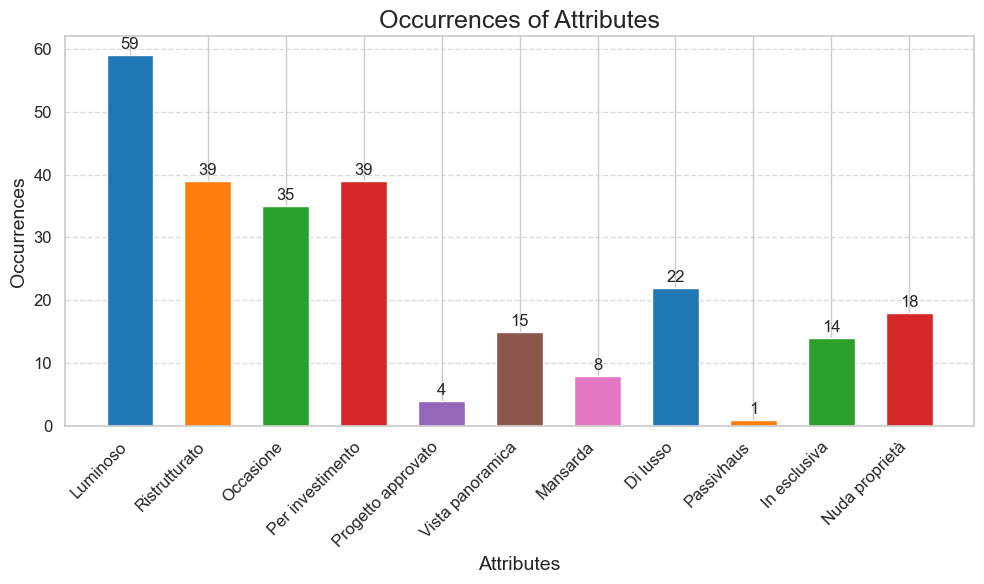

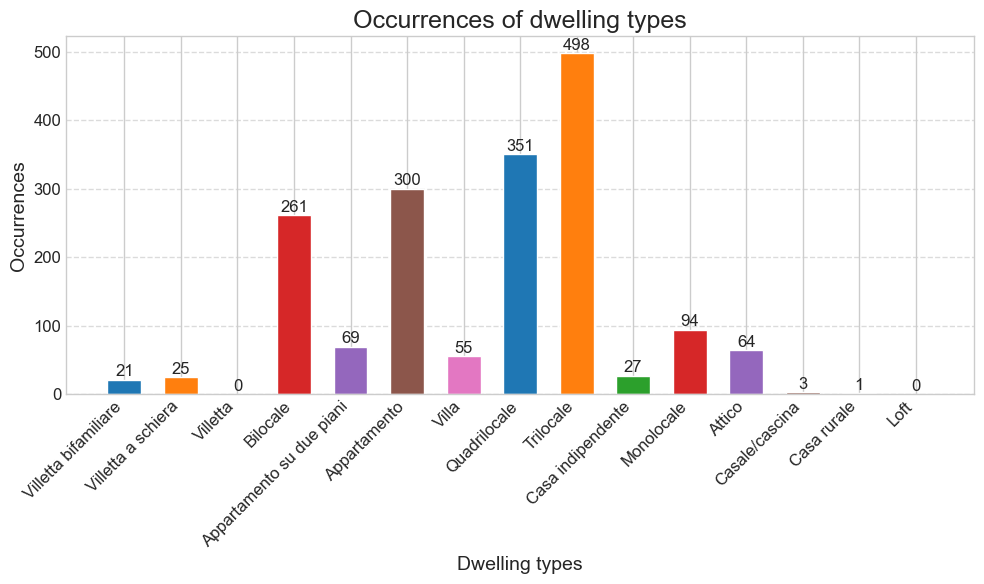

     Price Bedrooms Area m^2       Tags  \
0   285000        7      223  Occasione   
1  1300000       11      300        NaN   
2   200000        2       43        NaN   
3   565000        5      110        NaN   
4   270000        4       98        NaN   

                                          Image URLs          DwellingType  \
0  https://img4.idealista.it/blur/WEB_LISTING-M/0...  Villetta bifamiliare   
1  https://img4.idealista.it/blur/WEB_LISTING-M/0...                 Villa   
2  https://img4.idealista.it/blur/WEB_LISTING-M/0...              Bilocale   
3  https://img4.idealista.it/blur/WEB_LISTING-M/0...          Appartamento   
4  https://img4.idealista.it/blur/WEB_LISTING-M/0...          Quadrilocale   

                                             Address  \
0              via Santa Maria, 2, Pilastro, Bologna   
1                           Costa Saragozza, Bologna   
2                   Santo Stefano - Galvani, Bologna   
3                                Murri Alta, Bol

In [50]:
# List of all specific attributes available in idealista, we would use the list of attributes to create dummy columns based on
#the presence of that element in each row of df_merged["Tags"] column. 
attributes = ["Luminoso", "Ristrutturato", "Occasione", "Per investimento","Progetto approvato", 
              "Vista panoramica","Mansarda","Di lusso", "Passivhaus", "In esclusiva","Nuda proprietà"]

### Luminoso - Bright
### Ristrutturato - Renovated
### Occasione - Bargain / Opportunity
### Per investimento - For investment
### Progetto approvato - Approved project
### Vista panoramica - Panoramic view
### Mansarda - Attic
### Di lusso - Luxury
### Passivhaus - Passive house
### In esclusiva - Exclusive
### Nuda proprietà - Bare ownership





# add columns for each attribute and mark with 1 or 0 (dummy variables)
for attribute in attributes:
    df_merged[attribute] = df_merged["Tags"].apply(lambda x: 1 if isinstance(x, str) and attribute in x.split(", ") else 0)

# count for the occurrences of each attribute
attribute_counts = df_merged[attributes].sum()

# Plots of the distribution of those attributes
plt.figure(figsize=(10, 6))
bars = plt.bar(attribute_counts.index, attribute_counts.values, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                                                                       "#9467bd", "#8c564b", "#e377c2"], width=0.6)

# This add counts on top of the bars to make the chart more understandable
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1), ha="center", va="bottom", fontsize=12)

plt.title("Occurrences of Attributes", fontsize=18)
plt.xlabel("Attributes", fontsize=14)
plt.ylabel("Occurrences", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.style.use("seaborn-v0_8-whitegrid")

plt.show()




#do the same thing but for the other set of attributes (the dwelling type)
dwelling_types = ["Villetta bifamiliare", "Villetta a schiera", "Villetta", "Bilocale", "Appartamento su due piani", 
                  "Appartamento", "Villa", "Quadrilocale", "Trilocale", "Casa indipendente", "Monolocale", 
                  "Attico", "Casale/cascina", "Casa rurale","Loft"]

### Villetta bifamiliare - Semi-detached house
### Villetta a schiera - Terraced house / Townhouse
### Villetta - Cottage / Small villa
### Bilocale - One-bedroom apartment
### Appartamento su due piani - Duplex apartment
### Appartamento - Apartment
### Villa - Villa
### Quadrilocale - Four-room apartment
### Trilocale - Three-room apartment
### Casa indipendente - Detached house
### Monolocale - Studio apartment
### Attico - Penthouse
### Casale/cascina - Farmhouse
### Casa rurale - Rural house


# List of specific attributes
attributes = dwelling_types     # Add columns for each attribute and mark with 1 or 0 as before
for attribute in attributes:
    df_merged[attribute] = df_merged["DwellingType"].apply(lambda x: 1 if isinstance(x, str) and attribute in x.split(", ") else 0)

# Count occurrences of each attribute
attribute_counts = df_merged[attributes].sum()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(attribute_counts.index, attribute_counts.values, color=["#1f77b4", "#ff7f0e", "#2ca02c",
                                                                       "#d62728", "#9467bd", "#8c564b", "#e377c2"], width=0.6)

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1), ha="center", va="bottom", fontsize=12)

plt.title("Occurrences of dwelling types", fontsize=18)
plt.xlabel("Dwelling types", fontsize=14)
plt.ylabel("Occurrences", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.style.use("seaborn-v0_8-whitegrid") #this must be changed if it produces error, depending on the seaborn version/ packages installed. 

plt.show()

print(df_merged.head()) #print to get an idea of how the dataframe presents itself

In [51]:
#This code drops the DwellingType column because it is no longer useful since we have now the dummy variables
df_merged.drop(df_merged.columns[[3]], axis=1, inplace=True)

# remove rows with NaN or None values
df_reg = df_merged.dropna(inplace=False)
#put a maximum distance for the regression, doing so we can get rid of addresses that were mistakenly identified, as well as having a
#a correct estimate of the distance parameters and estimating the "Bologna only" effect in the housing market.  
df_reg_filtered = df_reg[df_reg["Distance"] <= 5]

#notice that in some cases there is a non numerical value in the area column, because of a format error in 2-3 listings
#get rid of the problematic rows by converting strings to numeric, it will produce a Nan, and then drop it
df_reg_filtered["Area m^2"] = pd.to_numeric(df_reg_filtered["Area m^2"], errors="coerce")

# Drop rows with NaN values in 'Area m^2' column
df_reg_filtered = df_reg_filtered.dropna(subset=["Area m^2"])

print(df_reg_filtered.head())

     Price Bedrooms  Area m^2  \
1  1300000       11     300.0   
2   200000        2      43.0   
4   270000        4      98.0   
6   336000        3      94.0   
7   355000        3      88.0   

                                          Image URLs  DwellingType  \
1  https://img4.idealista.it/blur/WEB_LISTING-M/0...         Villa   
2  https://img4.idealista.it/blur/WEB_LISTING-M/0...      Bilocale   
4  https://img4.idealista.it/blur/WEB_LISTING-M/0...  Quadrilocale   
6  https://img4.idealista.it/blur/WEB_LISTING-M/0...     Trilocale   
7  https://img4.idealista.it/blur/WEB_LISTING-M/0...     Trilocale   

                                             Address  \
1                           Costa Saragozza, Bologna   
2                   Santo Stefano - Galvani, Bologna   
4  via Camillo Ranzani, 17, San Vitale - Massaren...   
6           via Giuseppe Rivani, 39, Roveri, Bologna   
7           via Giuseppe Rivani, 39, Roveri, Bologna   

                Coordinates  Distance  Asta

C:\Users\utente1\AppData\Local\Temp\ipykernel_21244\2697861065.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg_filtered["Area m^2"] = pd.to_numeric(df_reg_filtered["Area m^2"], errors="coerce")


## <span style="font-family: Arial; color: #000000;">Regression Analysis</span>

<div style="font-size: 18px; line-height: 1.8; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
 <p>
 In this section, there are two types of regression analysis to model housing prices based on various factors.
 </p>

 <p>
 The first set of regressions adopts a "lin-lin" form, in order to identify linear relationships among variables. This initial model incorporates all variables derived from preceding steps, and it achieves an R-squared of 77%. Excluding non-significant variables minimally affects the R-squared, mainly because these variables were not that numerous in the dataset, as observed in the data analysis section. This explains their limited impact on price variability and so contribution in improving the R-squared.
 </p>
  
 <p>
 The second regression adopts a "log-lin" format, where the price variable is transformed in logarithms. While the R-squared values between the two models are not directly comparable due to the transformation of the dependent variable, this approach offers better insights on how different dwelling types influence percentage changes in housing prices relative to certain control variables.
 </p>
</div>


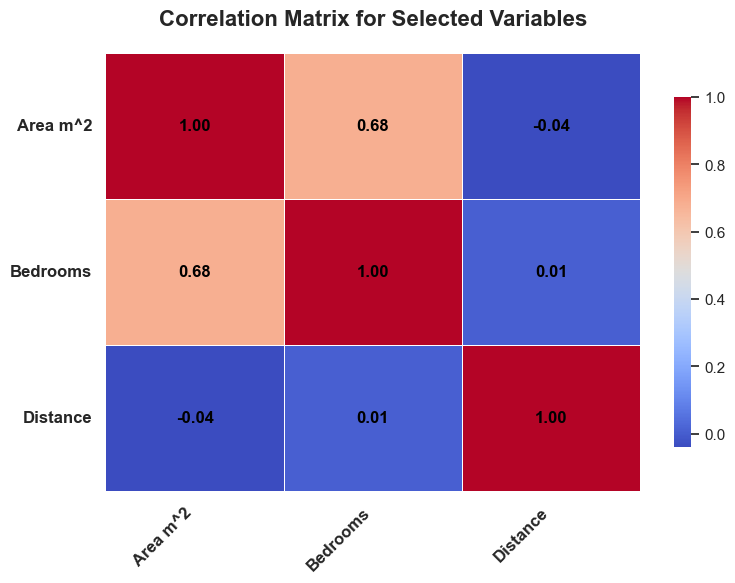

In [52]:
# For a correct estimation we need to analyze potential multicollinearity issues using a correlation matrix: we select only specific columns of interest
X = df_reg_filtered[["Area m^2", "Bedrooms", "Distance"]]

# Convert X to numeric if necessary
X = X.apply(pd.to_numeric, errors="coerce")  # Convert to numeric, coerce errors

# Drop rows with NaN values in any column
X = X.dropna()

# Compute the correlation matrix between the columns chosen above
corr_matrix = X.corr()

# plot the heatmap to graphically show the correlation between those variables
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # This sets a white grid background
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",          # This is the colormap we decided to use for the heatmap colors, red --> corr close to 1, blue --> -1 (or min value)
    fmt=".2f",
    linewidths=0.5,           # This indicates the width of the lines that will divide each cell.
    cbar_kws={"shrink": 0.8},  # This is set to shrink to 80% the original size of the keyword arguments for the color bar.
    annot_kws={"size": 12, "weight": "bold", "color": "black"}  #it specifies the font size, weight, and color.
)
plt.title("Correlation Matrix for Selected Variables", fontsize=16, fontweight="bold", pad=20)
plt.xticks(fontsize=12, rotation=45, ha="right", weight="bold")
plt.yticks(fontsize=12, rotation=0, weight="bold")
plt.tight_layout()
plt.show()






In [53]:
#"Price" as the target variable and columns from 7 to 35 as predictors
X = df_reg_filtered[["Area m^2", "Bedrooms"] + list(df_reg_filtered.columns[7:35])]
y = df_reg_filtered["Price"]  # Target variable

# Convert X to numeric if necessary
X = X.apply(pd.to_numeric, errors="coerce")  # Convert to numeric, coerce errors

# Drop rows with NaN values in any column
X = X.dropna()
y = y[X.index]  # Align y with X after dropping NaN rows. After dropping rows with NaN values in X, the indices of X change. y[X.index] selects only those entries in y that correspond to the remaining rows in X.

# Add constant to predictor for intercept
X = sm.add_constant(X)

# fit the OLS model
initial_model = sm.OLS(y, X).fit()

# Summary of the model
print("Initial Model Summary:")
print(initial_model.summary())

# Identify non-significant variables (p-value > 0.05)
non_significant_vars = initial_model.pvalues[initial_model.pvalues > 0.05].index

# Check if "const" is in the list and remove it if present
if "const" in non_significant_vars:
    non_significant_vars = non_significant_vars.drop("const")  # Keep the intercept

# Handle variables with nan p-values separately
nan_pvalue_vars = initial_model.pvalues[initial_model.pvalues.isna()].index

# Combine non-significant and nan p-value variables
vars_to_drop = list(non_significant_vars) + list(nan_pvalue_vars)

# Remove non-significant variables and variables with nan p-values
X_significant = X.drop(columns=vars_to_drop, errors='ignore')

# After dropping the non significant variables fit the OLS model with the significant variables only
# add heteroskedasticity 
try:
    final_model = sm.OLS(y, X_significant).fit(cov_type="HC3") #This could yield errors, in case it does it becomes like this: final_model = sm.OLS(y, X_significant).fit()
except Exception as e:
    print(f"Error fitting the model with HC3 standard errors: {e}")
    # Retry fitting without robust standard errors if the first attempt fails
    final_model = sm.OLS(y, X_significant).fit()

# Print final model summary
print("\nFinal Model Summary with robust standard errors (with significant variables only):")
print(final_model.summary())

Initial Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     157.9
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:08:16   Log-Likelihood:                -17330.
No. Observations:                1302   AIC:                         3.472e+04
Df Residuals:                    1274   BIC:                         3.486e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

C:\Users\utente1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 17
  warnings.warn('covariance of constraints does not have full '


<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Comments on estimations</h2>
</div>

<div style="font-size: 18px; line-height: 1.8; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
    <p>
        As illustrated by the chart below, there is a noticeable concentration of data points around the lower values of both axes, indicating a higher density of smaller prices. As the values increase, the dispersion of the data points widens, reflecting greater variability in higher prices. This observation suggests that incorporating heteroskedasticity robust standard errors might be necessary to obtain more accurate estimates.
        
As expected, the importance of the bedrooms variable reduces once in the model we include the dummy variables. This is because some dummies already contain information about the numbers of locals. So its presence in the model is redundant and leads to less accurate estimates. 
      
Then we can note that the distance factor becomes less important the higher is the distance from the center. This happens because for higher distances the variable loses its importance and meaning; instead of looking at the center of the city, it would analyze the general impact of the distance from Bologna. 
    </p>
</div>


In [1]:
y_pred = final_model.predict(X_significant)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.3)  # Scatter plot of actual vs predicted values
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linewidth=2)  # Regression line

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

NameError: name 'final_model' is not defined

In [55]:
#Log-lin model

#To continue our analysis we select only specific columns of interest
X = df_reg_filtered[["Area m^2", "Bedrooms","Asta_Tag", "Distance", "Ristrutturato", "Di lusso","Luminoso","Monolocale","Bilocale",
                     "Villetta bifamiliare","Villetta a schiera","Villa","Casa indipendente",
                     "Appartamento","Appartamento su due piani", "Quadrilocale", "Trilocale", "Attico", "Casale/cascina"]]

# aggregate the minor attributes into bigger ones, so we can study the general category instead of the specific one
X["Villa All"] = X["Villetta bifamiliare"] + X["Villetta a schiera"] + X["Villa"] + X["Casa indipendente"] #These are all villas
X["Appartamento All"] = X["Appartamento"] + X["Appartamento su due piani"] #All the apartments category
X["Mono/Bilocale"] = X["Monolocale"] + X["Bilocale"]   #All the small buildings with 1-2 locals


# Select only the summarized columns and any other predictors of interest
X = X[["Area m^2", "Distance","Asta_Tag", "Villa All", "Appartamento All","Quadrilocale","Trilocale","Attico","Ristrutturato", "Di lusso","Luminoso"]]


#Then like before we run the regression, but we modify the dependent variable by transforming it in logarithms
# Convert X to numeric if necessary
X = X.apply(pd.to_numeric, errors="coerce")  # Convert to numeric, coerce errors

# Drop rows with NaN values in any column
X = X.dropna()

# Natural logarithm of "Price" (dependent variable)
y_log = np.log(df_reg_filtered["Price"])  # Log transformation of Price

# Align y_log with X after dropping NaN rows
y_log = y_log[X.index]

# Add constant to predictor for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) model
log_model = sm.OLS(y_log, X).fit(cov_type="HC3")

# Print initial model summary
print("Log Model Summary:")
print(log_model.summary())


#When the dependent variable is in logs, the linear coefficients of the ind.variables represent the % increase for the dependent
#variable given a one-unit increase in them. So if distance increases by 1 km, we expect the price to drop by 8.9%, ceteris paribus. 

Log Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     163.1
Date:                Sat, 20 Jul 2024   Prob (F-statistic):          5.19e-235
Time:                        15:08:28   Log-Likelihood:                -338.99
No. Observations:                1302   AIC:                             702.0
Df Residuals:                    1290   BIC:                             764.0
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               1

C:\Users\utente1\AppData\Local\Temp\ipykernel_21244\336396715.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Villa All"] = X["Villetta bifamiliare"] + X["Villetta a schiera"] + X["Villa"] + X["Casa indipendente"] #These are all villas
C:\Users\utente1\AppData\Local\Temp\ipykernel_21244\336396715.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Appartamento All"] = X["Appartamento"] + X["Appartamento su due piani"] #All the apartments category
C:\Users\utente1\AppData\Local\Temp\ipykernel_2124

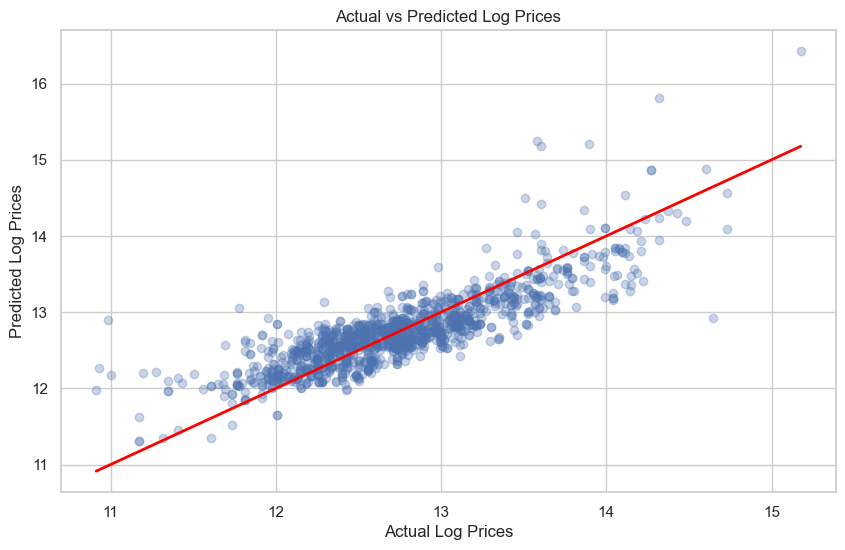

In [56]:
y_pred2 = log_model.predict(X)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred2, alpha=0.3)  # Scatter plot of actual vs predicted values
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], color="red", linewidth=2)  # To show the regression line

plt.xlabel("Actual Log Prices")
plt.ylabel("Predicted Log Prices")
plt.title("Actual vs Predicted Log Prices")
plt.show()

<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Further Regression Analysis Charts</h2>
</div>

<div style="font-size: 18px; line-height: 1.8; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
    <p>
        Based on the regression results discussed above, they conduct a detailed analysis of how specific attributes impact housing prices. The findings indicate that luxury buildings lead to substantial price increases, followed by properties that are renovated and bright. Attributes such as the number of rooms behave as expected, with a progressive increase in the % price increase as properties have more rooms, in comparison to the "monolocale/bilocale" categories.
    </p>
</div>



C:\Users\utente1\AppData\Local\Temp\ipykernel_21244\261890123.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_data = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]
C:\Users\utente1\AppData\Local\Temp\ipykernel_21244\261890123.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars1 = sns.barplot(x=selected_coeffs_1.index, y=selected_coeffs_1.values, palette="viridis", ax=ax1)
C:\Users\utente1\AppData\Local\Temp\ipykernel_21244\261890123.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars2 = sns.barplot(x=selected_coeffs_2.index, y=selected_coeffs_2.v

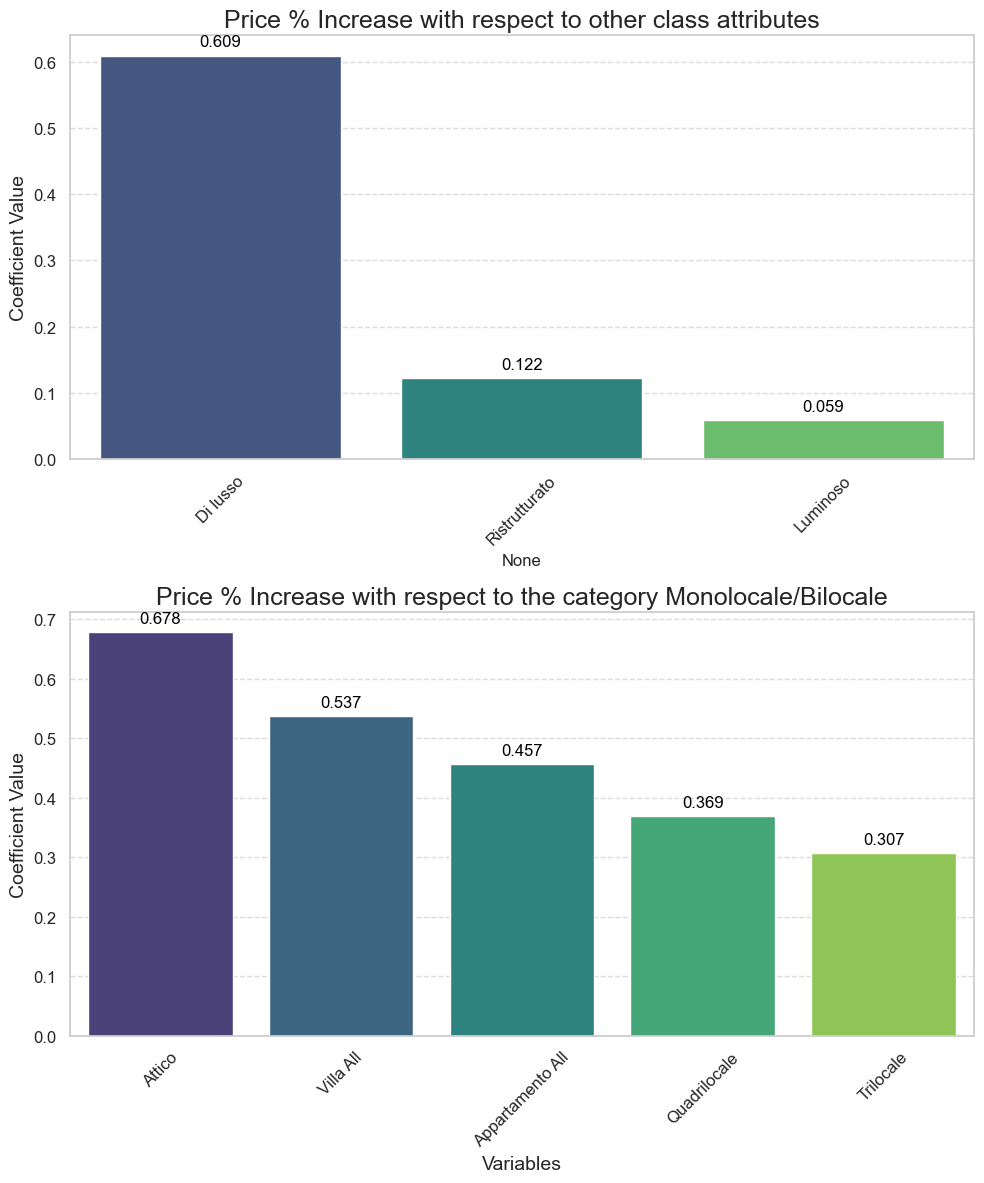

In [40]:
# Extract coefficients and their labels from the model summary
summary = log_model.summary()
results_data = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]
coefficients = results_data["coef"]
labels = coefficients.index

# First set of variables: "Ristrutturato", "Luminoso", "Di lusso"
selected_columns_1 = ["Ristrutturato", "Luminoso", "Di lusso"]
selected_coeffs_1 = coefficients[selected_columns_1].sort_values(ascending=False)

# Second set of variables: "Villa All", "Appartamento All", "Quadrilocale", "Trilocale", "Attico"
selected_columns_2 = ["Villa All", "Appartamento All", "Quadrilocale", "Trilocale", "Attico"]
selected_coeffs_2 = coefficients[selected_columns_2].sort_values(ascending=False)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plotting the first set of coefficients
bars1 = sns.barplot(x=selected_coeffs_1.index, y=selected_coeffs_1.values, palette="viridis", ax=ax1)
ax1.set_title("Price % Increase with respect to other class attributes", fontsize=18)
ax1.set_ylabel("Coefficient Value", fontsize=14)
ax1.tick_params(axis="x", rotation=45, labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Add values on top of the bars for the first plot
for bar, coef in zip(bars1.patches, selected_coeffs_1.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, round(coef, 3), 
             ha='center', va='bottom', fontsize=12, color='black')

# Plotting the second set of coefficients
bars2 = sns.barplot(x=selected_coeffs_2.index, y=selected_coeffs_2.values, palette="viridis", ax=ax2)
ax2.set_title("Price % Increase with respect to the category Monolocale/Bilocale", fontsize=18)
ax2.set_xlabel("Variables", fontsize=14)
ax2.set_ylabel("Coefficient Value", fontsize=14)
ax2.tick_params(axis="x", rotation=45, labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
ax2.grid(axis="y", linestyle="--", alpha=0.7)

# Add values on top of the bars for the second plot
for bar, coef in zip(bars2.patches, selected_coeffs_2.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, round(coef, 3), 
             ha="center", va="bottom", fontsize=12, color="black")

# Adjust layout and spacing
plt.tight_layout()

# Show plot
plt.show() 


<div style="background-color: #f0f0f0; padding: 10px; margin-bottom: 20px;">
    <h2 style="font-family: Arial; color: #000000; margin: 0;">Interactive Maps of Bologna</h2>
</div>

<div style="font-size: 18px; line-height: 1.8; margin-top: 30px; font-family: 'Times New Roman', serif; color: #000000; text-align: justify;">
 <p>
 In this part of the project, there are two interactive maps of the city of Bologna in which the dots represent the location of each listing. These maps can be used by real estate agents and potential buyers to analyze property price trends and make investment decisions based on the geographic price distributions of listings.
 </p>
 
 <p>
 The first map just shows the real estate prices in Bologna, Italy, using a color gradient from blue to red. Each dot represents a property, with colors indicating price levels—blue for lower prices, purple for middle prices and red for higher prices, up to the 95th percentile to exclude outliers.
 </p>

 <p>
 In the second map green and red dots represent areas with negative and positive residuals, respectively, indicating where the model underestimates or overestimates prices. Black dots highlight extreme residuals, more than three times the standard deviation. Each dot provides a popup with the address, price, and residual value and an image link for the listed house. The colormap at the top illustrates the residual gradient, helping to identify areas where the model predictions deviate significantly from actual prices.
 </p>
</div>


In [2]:
# Creation of a new DataFrame for plotting
df_plot = df_reg_filtered.copy()

# make sure that the "Coordinates" column is in string format
df_plot["Coordinates"] = df_plot["Coordinates"].astype(str)

# convert them from string to tuple
def convert_coordinates(coord_str):
    return tuple(map(float, coord_str.strip("()").split(", ")))

# convert function to the "Coordinates" column
df_plot["Coordinates"] = df_plot["Coordinates"].apply(convert_coordinates)

# filter outliers (calculated by looking at the 95th percentile of prices)
price_cutoff = df_plot["Price"].quantile(0.95)

# Generate the colormap ("red" to "blue") with vmin and vmax defined as the min price and max price (given by the cutoff of outliers)
colormap = cm.LinearColormap(colors=["blue","red"], vmin=df_plot["Price"].min(), vmax=price_cutoff.max())

# Function to convert price to color using the colormap
def price_to_color(price_cutoff):
    return colormap(price_cutoff)

# Initialize the map centered around the average location
map_center = [df_plot["Coordinates"].apply(lambda x: x[0]).mean(),
              df_plot["Coordinates"].apply(lambda x: x[1]).mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Iterate over each row in the dataframe df_plot
for idx, row in df_plot.iterrows():
    # Determine the color for the circle marker based on the property price
    color = price_to_color(row["Price"])
    
    # Create a circle marker for each property listing using folium
    folium.CircleMarker(
        location=row["Coordinates"],  # extracts the geographical location (latitude, longitude) of the marker
        radius=2,  # Set the radius of the circle marker
        color=color,  # Set the border color of the circle marker
        fill=True,  # Enable filling the circle with color
        fill_color=color,  # Set the fill color of the circle marker
        fill_opacity=1  # Set the opacity of the fill color (1 means fully opaque)
    ).add_to(m)  # Add the circle marker to the map object "m"

# Add the colormap to the map to show the gradient scale
colormap.add_to(m)  # Integrate the colormap, which provides a visual legend for the color gradient based on prices


# At the end we can finally save the map to an HTML file and display it
m.save("map_colored_by_price.html")

# Display the map 
m

NameError: name 'df_reg_filtered' is not defined

In [42]:
#Here there is the use of LinearColormap from branca.colormap
#This part is a bit different from before because instead of looking at prices we do the colormap based on residuals
#So is possible to identify the listings that are undervalued/overvalued relative to our model

#This predicts values using the final_model calculated before
predictions = final_model.predict(X_significant)

#Calculate the difference between predicted and actual estimates (the residuals)
difference = y - predictions

df_plot2 = df_plot.copy()
df_plot2["Residuals"] = difference

# Calculate the 95th percentile of residuals to filter out outliers again
res_cutoff = df_plot2["Residuals"].quantile(0.95)

# Determine the vmin and vmax for the colormap
vmin = df_plot2["Residuals"].min()
vmax = res_cutoff
deviation = np.std(df_plot2["Residuals"])

# Create the colormap
colormap = LinearColormap(
    colors=["darkgreen", "lightgreen", "red", "darkred"],
    vmin=-3*deviation,
    vmax=vmax,
    index=[-3*deviation, 0, 0, vmax],  # Adjust the index as needed based on your residual distribution
    caption="Residuals"
)

# Function to convert residuals to color using the colormap with error suppression
def residual_to_color(residual, std_dev):
    try:
        if abs(residual) > 3 * std_dev:
            return "black"  # Black for residuals more than 3 times the standard deviation
        elif residual < 0:
            return colormap(residual)  # Green shades for negative residuals
        else:
            return colormap(residual)  # Red shades for positive residuals
    except ValueError:
        return "black"  # Default color for any other cases

# Initialize the map centered around the average location
map_center = [df_plot2["Coordinates"].apply(lambda x: x[0]).mean(),
              df_plot2["Coordinates"].apply(lambda x: x[1]).mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Threshold for residuals to display on the map
residual_threshold = df_plot2["Residuals"].max()   # Adjust this threshold as needed to cut the upper max residual
# Identify identical coordinates
duplicate_coords = df_plot2[df_plot2.duplicated(subset=["Coordinates"], keep=False)]

# Convert the 'Coordinates' column to a set of tuples for efficient lookup
duplicate_coords_set = set(tuple(coord) for coord in duplicate_coords["Coordinates"])


# Add points to the map for residuals under the threshold with popups for addresses, price, and residuals
for idx, row in df_plot2.iterrows():
    if abs(row["Residuals"]) <= residual_threshold:
        color = residual_to_color(row["Residuals"], deviation)
        address = row["Address"]
        price = row["Price"]
        residual = row["Residuals"]
        image_urls = row["Image URLs"]
        
        # Split the image URLs by comma
        image_url_list = image_urls.split(",")
        
        # Filter URLs to keep only those ending with .jpg
        jpg_urls = [url.strip() for url in image_url_list if url.strip().endswith(".jpg")]

        # To make the link clickable we need to format the URLs into HTML links
        image_links = " ".join([f'<a href="{url}" target="_blank">Image</a>' for url in jpg_urls])

        
        # Introduce random perturbation within 20 meters (0.00018 degrees latitude/longitude) because some listings are
        #in the same coordinates (because same address), to avoid excluding them from the map we simply randomize their location
        #within a 20 meter range
        if tuple(row["Coordinates"]) in duplicate_coords_set:
            # Generate random perturbation values for latitude and longitude
            perturbation = np.random.uniform(-0.00009, 0.00009, size=2)  # Uniform random perturbation within the specified range
            perturbed_location = [row["Coordinates"][0] + perturbation[0],  # Adjust latitude with perturbation
                                  row["Coordinates"][1] + perturbation[1]]  # Adjust longitude with perturbation
        else:
            perturbed_location = row["Coordinates"]  # Use the original coordinates if not duplicated



        # Create HTML content for the popup
        popup_text = f"""
        <b>Address:</b> {address}<br>
        <b>Price:</b> €{price}<br>
        <b>Residual:</b> {residual:.2f}<br>
        <b>Image:</b> {image_links}<br>
        """
        
        folium.CircleMarker(
            location=perturbed_location,
            radius=2,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=1,
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(m)

# Add colormap to the map
m.add_child(colormap)

# Save the map to an HTML file
m.save("map_colored_by_residuals.html")

# Display the map
m
